# Product Sales Forecasting: LightGBM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_validate
from lightgbm import LGBMRegressor
import shap

In [ ]:
path = '/content/drive/MyDrive/Product Sales Forecasting/data/'

# Get train and test data using 'date' as the index
train = pd.read_csv(f'{path}train.csv', index_col='date', parse_dates=True)
test = pd.read_csv(f'{path}test.csv', index_col='date', parse_dates=True)

# Get list of closed days
test_closed_days = test[test['closed_day'] == 1].index

# Remove rows for closed days
train = train[train['closed_day'] == 0].drop('closed_day', axis=1)
test = test.drop('closed_day', axis=1)

X_train = train.drop('qty', axis=1)
y_train = train['qty']

X_test = test.drop('qty', axis=1)
y_test = test['qty']

# Time Series split for cross-validations
cv = TimeSeriesSplit(n_splits=13, test_size=28)

# random_state
rs = 874

In [ ]:
train.describe()

,qty,year,month,week,day_of_week,day_of_month,week_of_month,is_weekend,is_holiday,back_to_school,...,lag_41_mean_3,lag_42_mean_7,lag_42_mean_14,lag_42_mean_30,lag_42_mean_60,lag_48_mean_3,lag_49_mean_7,lag_49_mean_14,lag_49_mean_30,lag_49_mean_60
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,...,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,6.313357,2021.232605,6.254444,25.369731,3.000508,15.733367,2.699848,0.285424,0.027933,0.035551,...,6.266802,6.259160,6.258362,6.248417,6.233291,6.254952,6.257564,6.253428,6.239225,6.226316
std,4.462448,1.578158,3.450251,15.044798,1.998856,8.782576,1.267882,0.451731,0.164823,0.185215,...,3.109549,2.368545,2.025774,1.720428,1.493906,3.110289,2.369135,2.028464,1.726325,1.499118
min,0.000000,2019.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.333333,1.571429,2.000000,2.600000,3.200000,0.333333,1.571429,2.000000,2.600000,3.200000
25%,3.000000,2020.000000,3.000000,12.000000,1.000000,8.000000,2.000000,0.000000,0.000000,0.000000,...,4.000000,4.714286,4.857143,5.033333,4.866667,4.000000,4.714286,4.785714,5.000000,4.866667
50%,6.000000,2021.000000,6.000000,24.000000,3.000000,16.000000,3.000000,0.000000,0.000000,0.000000,...,6.000000,6.000000,6.142857,6.200000,6.383333,6.000000,6.000000,6.142857,6.200000,6.383333
75%,9.000000,2023.000000,9.000000,38.000000,5.000000,23.000000,4.000000,1.000000,0.000000,0.000000,...,8.000000,7.428571,7.357143,7.266667,7.516667,8.000000,7.428571,7.357143,7.266667,7.516667
max,36.000000,2024.000000,12.000000,53.000000,6.000000,31.000000,5.000000,1.000000,1.000000,1.000000,...,26.333333,19.000000,14.428571,11.066667,9.050000,26.333333,19.000000,14.428571,11.066667,9.050000


In [ ]:
print("Number of features =", train.shape[1] - 1)
np.array(train.columns)

Number of features = 108


array(['qty', 'year', 'month', 'week', 'day_of_week', 'day_of_month',
       'week_of_month', 'is_weekend', 'is_holiday', 'back_to_school',
       '2d_to_christmas', '6d_to_christmas', '10d_to_christmas',
       '14d_to_christmas', 'price_change_30', 'price_change_60',
       'price_change_90', 'price_change_120', 'price_change_180',
       'price_change_240', 'price_change_365', 'lag_28', 'lag_29',
       'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35',
       'lag_36', 'lag_76', 'lag_77', 'lag_78', 'lag_79', 'lag_80',
       'lag_81', 'lag_82', 'lag_83', 'lag_84', 'lag_85', 'lag_132',
       'lag_133', 'lag_134', 'lag_135', 'lag_136', 'lag_137', 'lag_138',
       'lag_139', 'lag_140', 'lag_141', 'lag_356', 'lag_357', 'lag_358',
       'lag_359', 'lag_360', 'lag_361', 'lag_362', 'lag_363', 'lag_364',
       'lag_365', 'lag_28_mean_3', 'lag_28_std_3', 'lag_28_max_3',
       'lag_28_min_3', 'lag_28_mean_7', 'lag_28_std_7', 'lag_28_max_7',
       'lag_28_min_7', 'lag_28_mean_1

In [ ]:
def evaluate_preds(y, y_pred, label):
    '''
        Return RMSE, MAE, and sMAPE scores
        y, y_pred, and label may be tuples of same length for evaluation on
        multiple sets
    '''

    # Compute sMAPE
    def smape_score(y_true, y_pred):
      denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
      diff = np.abs(y_pred - y_true)
      mask = denominator != 0 # Avoid division by zero
      smape_val = np.mean(diff[mask] / denominator[mask]) * 100
      return smape_val

    trues = y if isinstance(y, (tuple)) else (y,)
    preds = y_pred if isinstance(y_pred, (tuple)) else (y_pred,)

    rmse = []
    mae = []
    smape = []

    for true, pred in zip(trues, preds):
      rmse.append(round(root_mean_squared_error(true, pred), 4))
      mae.append(round(mean_absolute_error(true, pred), 4))
      smape.append(round(smape_score(true, pred), 4))

    scores = pd.DataFrame({'RMSE': rmse, 'MAE': mae, 'sMAPE': smape})
    scores.index = label if isinstance(label, (tuple)) else (label,)

    return(scores)

## LightGBM

In [ ]:
# Get the feature importances
def get_importances(mod, col_names):
  importances = {}
  for score, name in zip(mod.feature_importances_, col_names):
      importances[name] = score
  return importances

# Returns test set forecast and train/test scores
def rolling_cv(X_train, X_test, params, label='', get_shap=False):
  fitteds = []
  forecasts = []
  train_scores = []
  test_scores = []
  importances = []
  shap_values = []
  cols = list(X_train.columns)

  for i in range(0, 364, 28):
    X_train_fold = pd.concat([X_train, X_test[:i]])
    y_train_fold = pd.concat([y_train, y_test[:i]])
    X_test_fold = X_test[i:i + 28]
    y_test_fold = y_test[i:i + 28]

    mod = LGBMRegressor(**params, random_state=rs, verbose=-1)
    mod.fit(X_train_fold, y_train_fold)

    fitted = mod.predict(X_train_fold)
    forecast = mod.predict(X_test_fold)

    # Set forecasts for closed days (i.e. Christmas, New Year's Day) to 0
    forecast[X_test_fold.index.isin(test_closed_days)] = 0

    fitteds.append(fitted)
    forecasts.append(forecast)

    train_score = evaluate_preds(y_train_fold, fitted, f'Fold {i // 28}')
    test_score = evaluate_preds(y_test_fold, forecast, f'Fold {i // 28}')

    train_scores.append(train_score)
    test_scores.append(test_score)

    importances.append(get_importances(mod, cols))

    if get_shap:
      explainer = shap.Explainer(mod, X_train_fold)
      shap_values.append(np.abs(explainer(X_train_fold, check_additivity=False).values))

  train_scores = pd.concat(train_scores).mean().round(4).to_frame().T
  test_scores = pd.concat(test_scores).mean().round(4).to_frame().T
  train_scores.index = [f"{label} Train Scores"]
  test_scores.index = [f"{label} Test Scores"]

  avg_importances = {k: sum(d[k] for d in importances) / len(importances) for k in importances[0]}

  if get_shap:
    avg_abs_shap = np.vstack(shap_values).mean(axis=0)

  return np.concatenate(forecasts), pd.concat([train_scores, test_scores]), avg_importances, avg_abs_shap if get_shap else None

# Print sorted list of importances
def print_importances(importances):
  sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
  print('Feature Importances')
  for col, score in sorted_importances:
    print(f"{col}: {round(score, 4)}")

# Get SHAP values, and optionally print
def get_shap(shap_vals, cols=X_train.columns, print_shap=False):
  shap_importance = pd.DataFrame({
    'col': cols,
    'score': shap_vals
  }).sort_values(by='score', ascending=False)

  if print_shap:
    print('SHAP Importances')
    for i, row in shap_importance.iterrows():
      print(f"{row['col']}: {round(row['score'], 4)}")

  return shap_importance

# Report results of grid search
def grid_search_results(gridsearch, top_n=None):
    results = gridsearch.cv_results_
    params_df = pd.DataFrame(list(results['params']))
    scores_df = pd.DataFrame({
        'mean_train_score': results['mean_train_score'],
        'mean_cv_score': results['mean_test_score']
    })
    df = pd.concat([params_df, scores_df], axis=1)
    df = df.sort_values(by='mean_cv_score', ascending=False)
    df = df.reset_index(drop=True)
    return df.head(top_n) if top_n else df

# Plot forecast
def plot_forecast(y_train, y_test, forecast, title):
  pred = pd.Series(forecast, index=y_test.index)

  plt.figure(figsize=(16, 4))
  y_train.iloc[-364:].plot(label='Train')
  y_test.plot(label='Actual')
  pred.plot(label='Forecast')
  for i in range(0, len(y_test), 28):
    plt.axvline(x=y_test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
# LightGBM Randomized Search (full model)
'''
param_grid = {
    'subsample': [0.4, 0.6, 0.8, 1.0],
    'num_leaves': [15, 31, 63, 127],
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

start_time = time.time()

clf = RandomizedSearchCV(LGBMRegressor(random_state=rs), param_grid, n_iter=30, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1, return_train_score=True)
clf.fit(X_train, y_train)

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")
grid_search_results(clf, 10)
'''

'\nparam_grid = {\n    \'subsample\': [0.4, 0.6, 0.8, 1.0],\n    \'num_leaves\': [15, 31, 63, 127],\n    \'n_estimators\': [100, 300, 500, 1000],\n    \'max_depth\': [-1, 5, 10, 15],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'colsample_bytree\': [0.6, 0.7, 0.8, 0.9, 1.0]\n}\n\nstart_time = time.time()\n\nclf = RandomizedSearchCV(LGBMRegressor(random_state=rs), param_grid, n_iter=30, scoring=\'neg_mean_squared_error\', cv=cv, n_jobs=-1, verbose=1, return_train_score=True)\nclf.fit(X_train, y_train)\n\nprint(f"Runtime: {round(time.time() - start_time, 2)} seconds")\ngrid_search_results(clf, 10)\n'

100%|===================| 2303/2305 [00:24<00:00]       

,RMSE,MAE,sMAPE
LightGBM (all features) Train Scores,3.2384,2.5405,49.7499
LightGBM (all features) Test Scores,3.7024,2.9955,64.6052


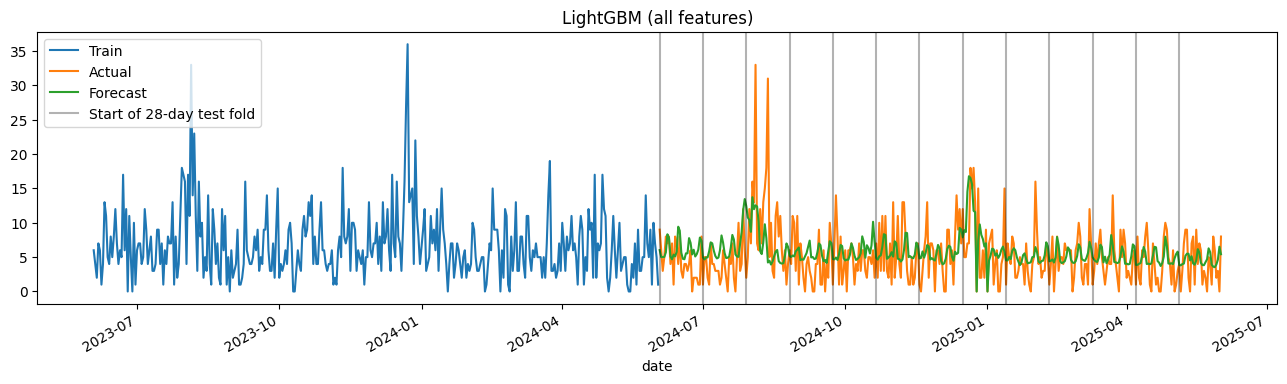

In [ ]:
# Fit full model with best parameters
params = {
    'subsample': 0.6,
    'num_leaves': 15,
    'n_estimators': 300,
    'max_depth': 15,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6
}

forecast_full, scores_full, importances_full, shap_vals_full = rolling_cv(X_train, X_test, params, label='LightGBM (all features)', get_shap=True)
display(scores_full)
plot_forecast(y_train, y_test, forecast_full, 'LightGBM (all features)')

In [ ]:
# Fit model on training dataset and get the time to fit the model
start_time = time.time()
mod = LGBMRegressor(**params, random_state=rs, verbose=-1).fit(X_train, y_train)
print(f"Fit time: {round(time.time() - start_time, 2)} seconds")

Fit time: 0.46 seconds


In [ ]:
print_importances(importances_full)

Feature Importances
day_of_week: 184.0769
lag_359_mean_7: 154.8462
back_to_school: 121.7692
week: 119.8462
lag_140: 107.6923
day_of_month: 103.0
lag_49_mean_60: 101.8462
lag_28: 99.3846
lag_49_mean_30: 97.8462
lag_84: 95.3846
lag_139: 95.3846
6d_to_christmas: 89.3077
lag_28_mean_90: 83.8462
lag_363_mean_3: 81.8462
lag_141: 81.3077
lag_77: 77.2308
lag_349_mean_3: 77.0769
lag_28_std_60: 71.8462
lag_28_std_90: 71.6154
lag_28_std_180: 71.3077
lag_359: 64.2308
lag_28_std_30: 63.8462
lag_42_mean_60: 62.3077
lag_42_mean_14: 54.3846
lag_28_std_3: 52.0
14d_to_christmas: 50.2308
lag_363: 47.6154
is_weekend: 46.3846
year: 46.1538
lag_365: 45.6154
lag_133: 44.8462
lag_345_mean_7: 43.8462
lag_361: 42.0769
lag_28_mean_180: 40.9231
lag_34_mean_3: 40.7692
lag_35_mean_60: 39.6154
month: 39.4615
lag_48_mean_3: 39.2308
lag_85: 38.6923
lag_362: 38.6923
lag_28_mean_30: 37.5385
lag_352_mean_7: 37.0
lag_30: 36.8462
lag_35_mean_14: 36.0769
lag_79: 35.2308
lag_82: 34.8462
lag_360: 34.8462
lag_49_mean_14: 32.46

In [ ]:
shap_importances = get_shap(shap_vals_full, print_shap=True)

SHAP Importances
day_of_week: 0.4936
lag_28_mean_90: 0.2246
is_weekend: 0.2118
lag_359_mean_7: 0.1727
lag_49_mean_30: 0.159
lag_49_mean_60: 0.1554
back_to_school: 0.1521
lag_140: 0.1247
6d_to_christmas: 0.1143
lag_84: 0.1109
lag_28: 0.1025
lag_363_mean_3: 0.0991
week: 0.0767
lag_28_std_180: 0.072
lag_28_std_90: 0.0695
lag_28_std_60: 0.0647
lag_42_mean_60: 0.0647
lag_349_mean_3: 0.0646
14d_to_christmas: 0.0578
year: 0.0554
lag_28_mean_180: 0.0543
lag_35_mean_60: 0.0538
lag_77: 0.0531
day_of_month: 0.0476
lag_139: 0.0432
lag_133: 0.0393
lag_141: 0.0389
lag_361: 0.0367
lag_28_std_30: 0.0362
lag_48_mean_3: 0.0334
lag_85: 0.0323
lag_34_mean_3: 0.0321
lag_82: 0.0321
lag_28_min_14: 0.0311
lag_42_mean_14: 0.0267
lag_132: 0.0257
month: 0.0248
lag_359: 0.0246
lag_28_max_180: 0.0218
10d_to_christmas: 0.0217
lag_363: 0.0216
lag_360: 0.018
lag_35_mean_14: 0.0169
lag_30: 0.0167
lag_345_mean_7: 0.0165
lag_28_min_60: 0.0165
lag_28_std_3: 0.0162
lag_352_mean_7: 0.0157
lag_28_mean_14: 0.0155
lag_365: 0.

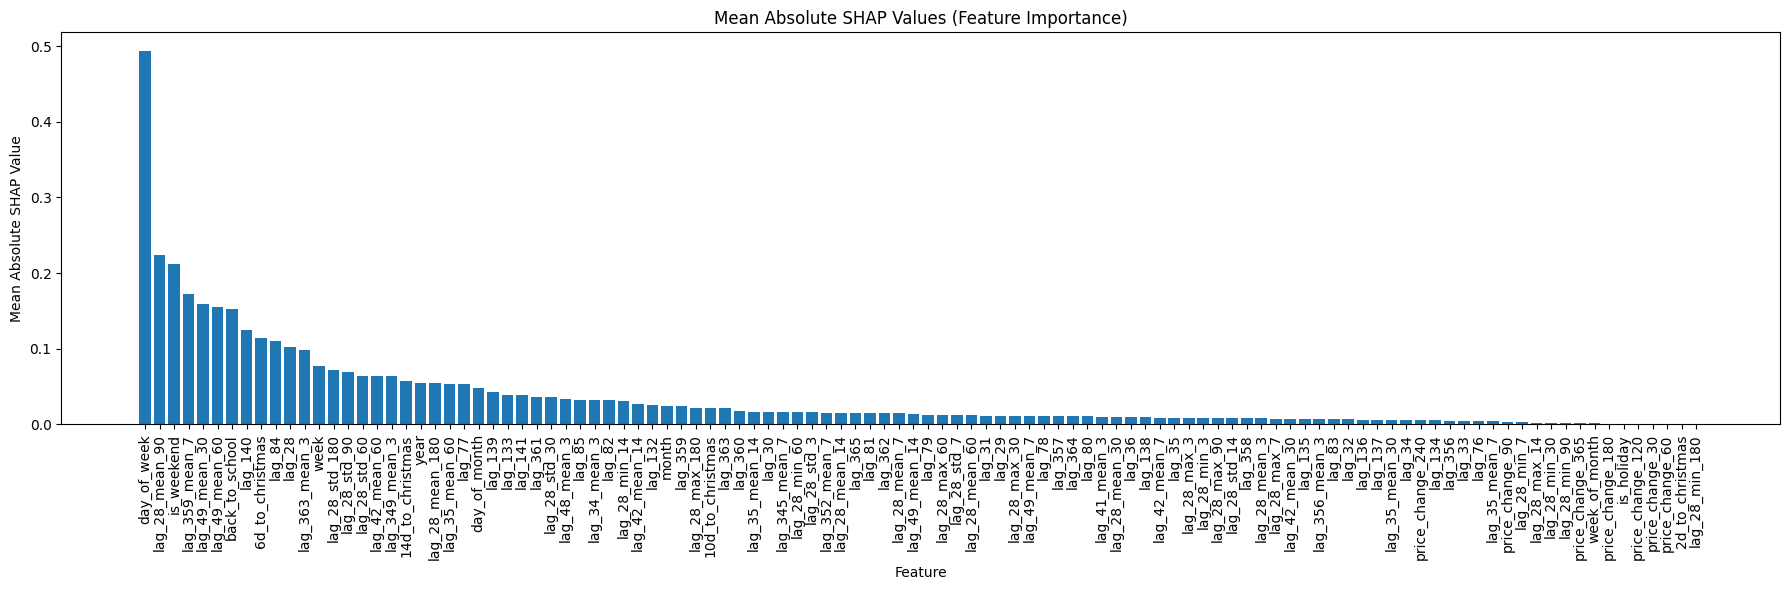

In [ ]:
# Plot SHAP Values
plt.figure(figsize=(18, 6))
plt.bar(shap_importances['col'], shap_importances['score'])
plt.title('Mean Absolute SHAP Values (Feature Importance)')
plt.xlabel('Feature')
plt.ylabel('Mean Absolute SHAP Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Feature Selection using SHAP values

In [ ]:
# Remove features based on threshold for mean absolute SHAP value
'''
start_time = time.time()

best_score = float('inf')
val_scores = []

for i in range(1, 11):
  threshold = i * 0.01
  features = shap_importances[shap_importances['score'] >= threshold]['col']

  param_grid = {
    'subsample': [0.6, 0.8, 1.0],
    'num_leaves': [15, 31, 63],
    'n_estimators': [100, 300, 500],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05],
    'colsample_bytree': [0.6, 0.8, 1.0]
  }

  start_time = time.time()

  clf = RandomizedSearchCV(LGBMRegressor(random_state=rs), param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
  clf.fit(X_train[features], y_train)

  val_score = -clf.best_score_ # MSE of best estimator
  val_scores.append(val_score)

  if val_score <= best_score:
    best_score = val_score
    best_threshold = threshold
    best_num_features = len(features)

  result = pd.DataFrame({
    'threshold': [threshold],
    'num_features': [len(features)],
    'val_score (MSE)': [val_score]
  }, index=[i])
  display(result)

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")
print(f'Best Threshold = {best_threshold}')
print(f'Best Number of Features = {best_num_features}')

plt.figure(figsize=(16, 4))
plt.plot(np.arange(0.01, 0.11, 0.01), val_scores)
plt.title('Validation Score (Mean Squared Error) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Validation Score')
plt.grid(True)
plt.show()
'''

'\nstart_time = time.time()\n\nbest_score = float(\'inf\')\nval_scores = []\n\nfor i in range(1, 11):\n  threshold = i * 0.01\n  features = shap_importances[shap_importances[\'score\'] >= threshold][\'col\']\n\n  param_grid = {\n    \'subsample\': [0.6, 0.8, 1.0],\n    \'num_leaves\': [15, 31, 63],\n    \'n_estimators\': [100, 300, 500],\n    \'max_depth\': [-1, 5, 10, 15],\n    \'learning_rate\': [0.01, 0.05],\n    \'colsample_bytree\': [0.6, 0.8, 1.0]\n  }\n\n  start_time = time.time()\n\n  clf = RandomizedSearchCV(LGBMRegressor(random_state=rs), param_grid, n_iter=10, scoring=\'neg_mean_squared_error\', cv=cv, n_jobs=-1)\n  clf.fit(X_train[features], y_train)\n\n  val_score = -clf.best_score_ # MSE of best estimator\n  val_scores.append(val_score)\n\n  if val_score <= best_score:\n    best_score = val_score\n    best_threshold = threshold\n    best_num_features = len(features)\n\n  result = pd.DataFrame({\n    \'threshold\': [threshold],\n    \'num_features\': [len(features)],\n    

In [ ]:
threshold = 0.07
reduced_features = shap_importances[shap_importances['score'] >= threshold]['col']
print(f'Original number of features = {X_train.shape[1]}')
print(f'Reduced number of features = {len(reduced_features)}')
print(f'Reduced feature list: {list(reduced_features)}')

Original number of features = 108
Reduced number of features = 14
Reduced feature list: ['day_of_week', 'lag_28_mean_90', 'is_weekend', 'lag_359_mean_7', 'lag_49_mean_30', 'lag_49_mean_60', 'back_to_school', 'lag_140', '6d_to_christmas', 'lag_84', 'lag_28', 'lag_363_mean_3', 'week', 'lag_28_std_180']


In [ ]:
# LightGBM Randomized Search (reduced model)
'''
param_grid = {
    'subsample': [0.4, 0.6, 0.8, 1.0],
    'num_leaves': [15, 31, 63, 127],
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

start_time = time.time()

clf = RandomizedSearchCV(LGBMRegressor(random_state=rs), param_grid, n_iter=30, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1, return_train_score=True)
clf.fit(X_train[reduced_features], y_train)

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")
grid_search_results(clf, 10)
'''

'\nparam_grid = {\n    \'subsample\': [0.4, 0.6, 0.8, 1.0],\n    \'num_leaves\': [15, 31, 63, 127],\n    \'n_estimators\': [100, 300, 500, 1000],\n    \'max_depth\': [-1, 5, 10, 15],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'colsample_bytree\': [0.6, 0.7, 0.8, 0.9, 1.0]\n}\n\nstart_time = time.time()\n\nclf = RandomizedSearchCV(LGBMRegressor(random_state=rs), param_grid, n_iter=30, scoring=\'neg_mean_squared_error\', cv=cv, n_jobs=-1, verbose=1, return_train_score=True)\nclf.fit(X_train[reduced_features], y_train)\n\nprint(f"Runtime: {round(time.time() - start_time, 2)} seconds")\ngrid_search_results(clf, 10)\n'

,RMSE,MAE,sMAPE
LightGBM (reduced features) Train Scores,3.3475,2.6026,50.3746
LightGBM (reduced features) Test Scores,3.7016,2.9455,63.6657


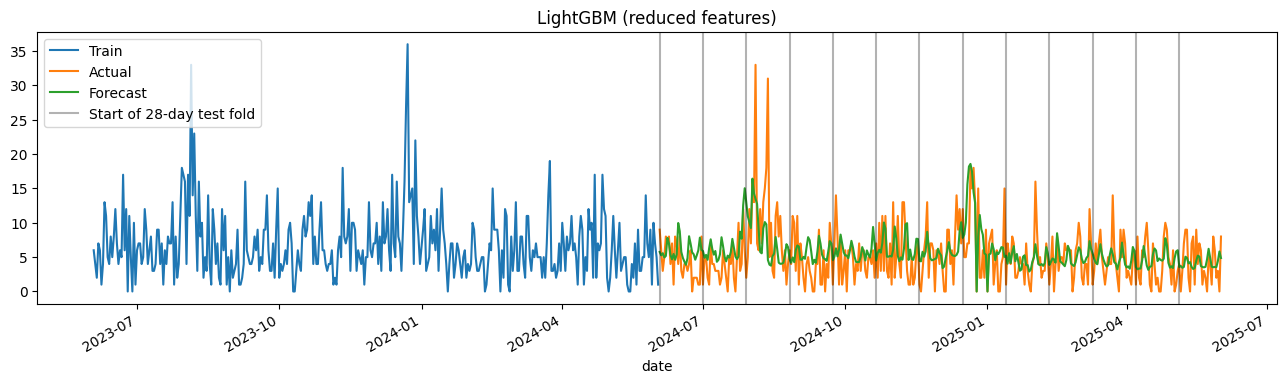

In [ ]:
# Fit reduced model with best parameters
params = {
    'subsample': 0.8,
    'num_leaves': 15,
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8
}

forecast_red, scores_red, _, _ = rolling_cv(X_train[reduced_features], X_test[reduced_features], params, label='LightGBM (reduced features)')
display(scores_red)
plot_forecast(y_train, y_test, forecast_red, 'LightGBM (reduced features)')

In [ ]:
# Fit model on training dataset and get the time to fit the model
start_time = time.time()
mod = LGBMRegressor(**params, random_state=rs, verbose=-1).fit(X_train[reduced_features], y_train)
print(f"Fit time: {round(time.time() - start_time, 2)} seconds")

Fit time: 0.05 seconds


,RMSE,MAE,sMAPE
LightGBM (reduced features) Train Scores,3.3475,2.6026,50.3746
LightGBM (reduced features) Test Scores,3.7016,2.9455,63.6657
LightGBM (all features) Train Scores,3.2384,2.5405,49.7499
LightGBM (all features) Test Scores,3.7024,2.9955,64.6052


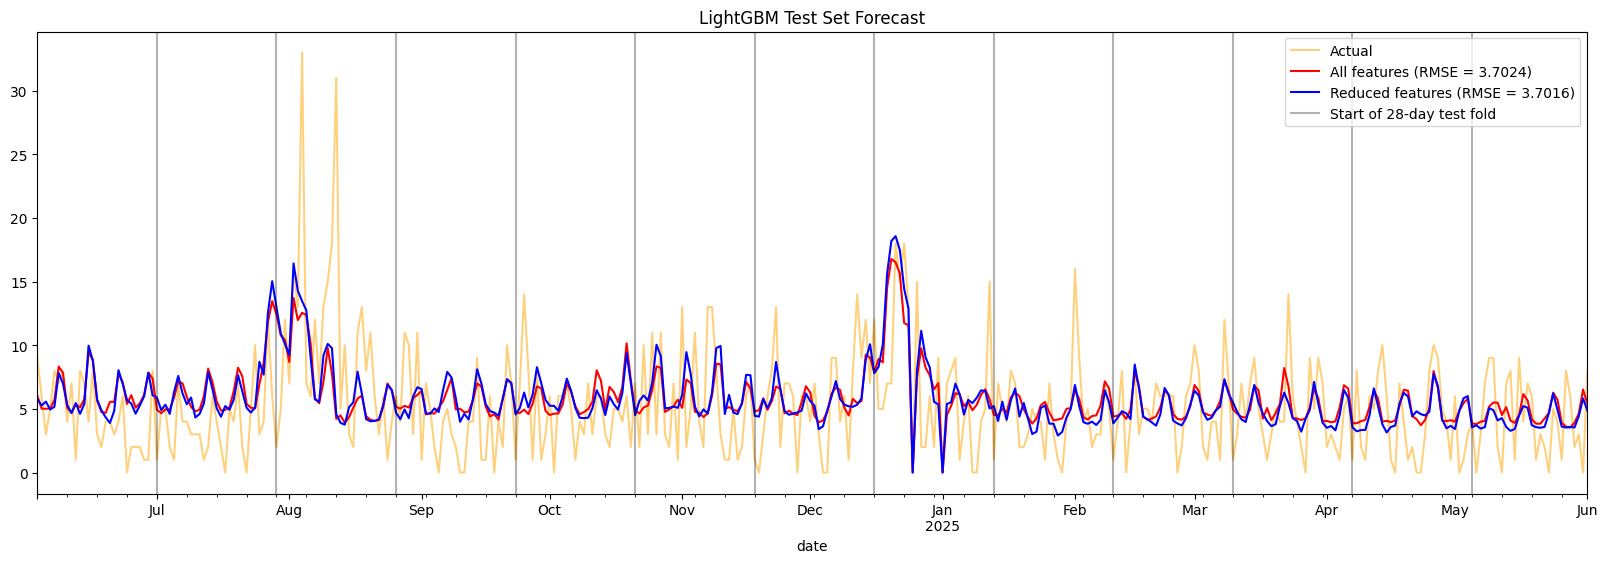

In [ ]:
display(pd.concat([scores_red, scores_full]))

plt.figure(figsize=(20, 6))
y_test.plot(label='Actual', alpha=0.5, color='orange')
pd.Series(forecast_full, index=y_test.index).plot(label=f"All features (RMSE = {scores_full.iloc[1]['RMSE']})", color='red')
pd.Series(forecast_red, index=y_test.index).plot(label=f"Reduced features (RMSE = {scores_red.iloc[1]['RMSE']})", color='blue')
for i in range(0, test.shape[0], 28):
  plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)

plt.title('LightGBM Test Set Forecast')
plt.legend()
plt.show()

## Residual Analysis

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

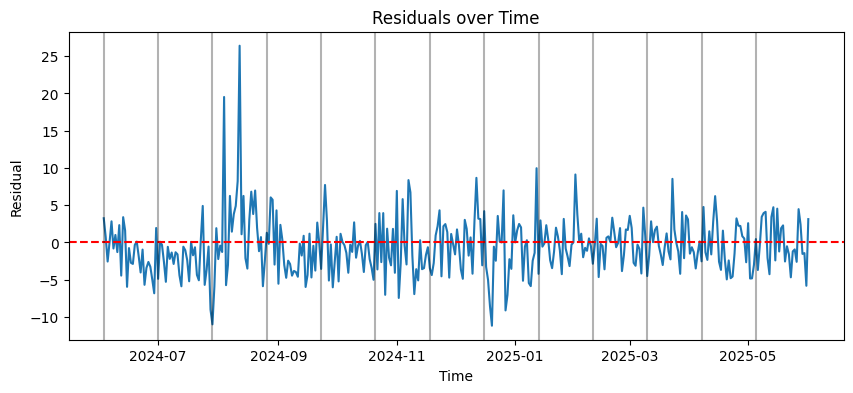

In [ ]:
residuals = test['qty'] - forecast_red

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--', color='red')
for i in range(0, test.shape[0], 28):
  plt.axvline(x=test.index[i], color='black', linestyle='-', alpha=0.3, label='Start of 28-day test fold' if i == 0 else None)
plt.show()

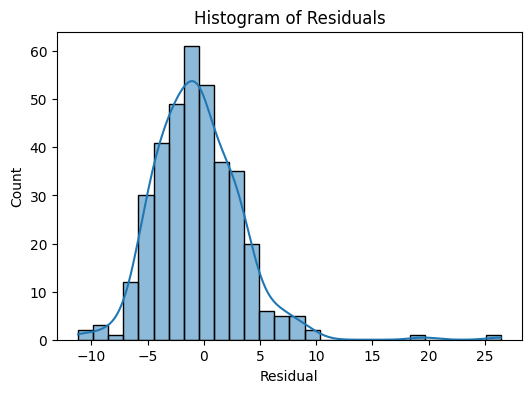

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.show()

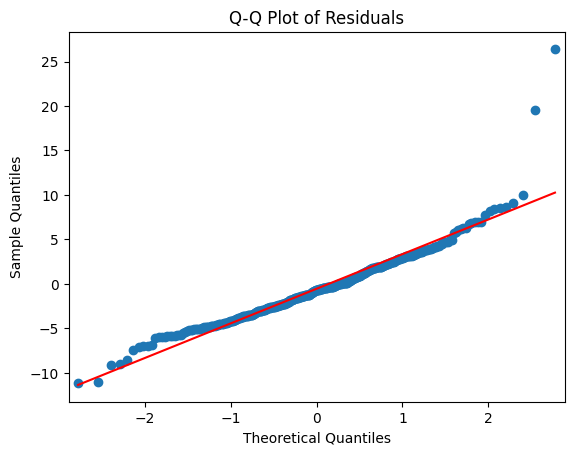

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

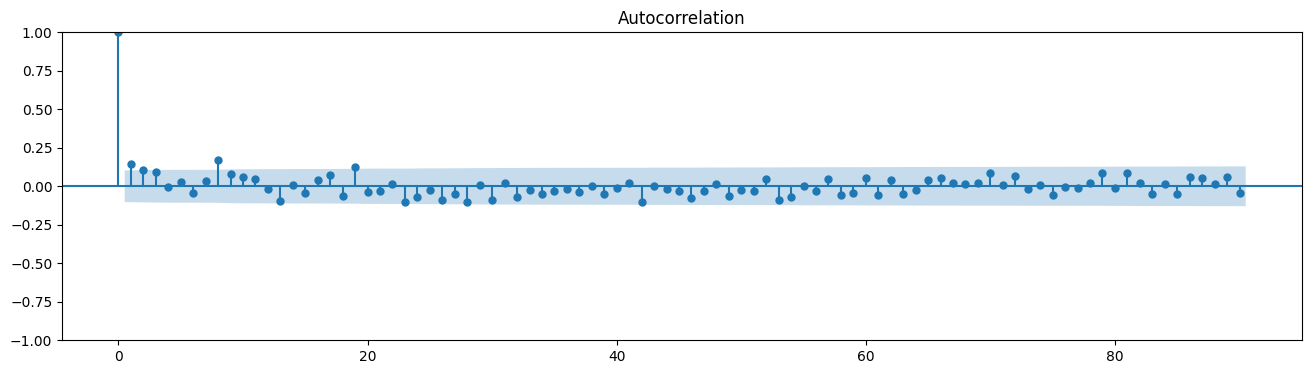

In [ ]:
plot_acf(residuals, lags=90).set_size_inches(16, 4)
plt.show()

In [ ]:
#@title Export Best Test Forecasts to CSV File

best_forecast = pd.Series(forecast_red, index=y_test.index, name='forecast')
best_forecast.to_csv(f'{path}forecast_lightgbm.csv', index=True, index_label='date')